In this submission, only the most basic techniques will be used to evaluate the effectiveness first.

In [1]:
import numpy as np
import pandas as pd

train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

### Data handling

First, check whether there are null values in the train and test dataset.

In [2]:
train_dataset.isnull().any().any()

False

In [3]:
test_dataset.isnull().any().any()

False

As the id columns will not contribute to the classification task, there is no need to keep them.

In [4]:
train_dataset = train_dataset.drop(["id"], axis = 1)
target = train_dataset["target"]

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_dataset.drop('target',axis=1), target, test_size = 0.25, random_state = 42)

Scale the features.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Various Scikit-Learn classification algorithms will be used.

### knn

Find the best value for k first.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (2,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x_train, y_train, cv=5)
    scores.append(np.mean(score))

[Text(0.5, 0, 'K Values'), Text(0, 0.5, 'Accuracy Score')]

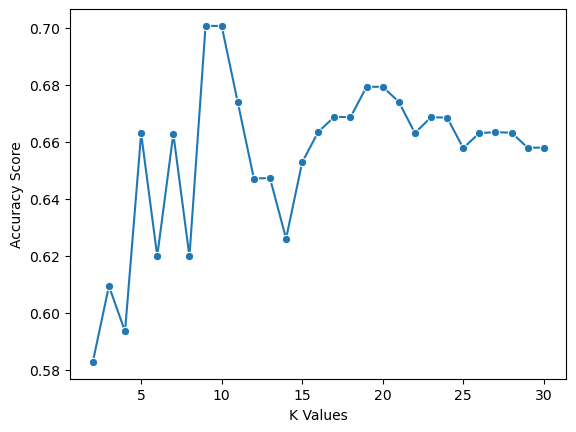

In [8]:
import seaborn as sns

plt = sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.set(xlabel='K Values', ylabel='Accuracy Score')

In [9]:
best_index = np.argmax(scores)
best_k = k_values[best_index]
print(best_k)

9


Train the knn model using the best k value found.

In [10]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [11]:
from sklearn.metrics import accuracy_score

knn_y_pred = knn.predict(x_test)
print("Accuracy:", accuracy_score(y_test, knn_y_pred))

Accuracy: 0.6031746031746031


### decision tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(x_train,y_train)

In [13]:
dt_y_pred = clf.predict(x_test)

In [14]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, dt_y_pred))

Accuracy: 0.6825396825396826


### random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

In [16]:
from sklearn.model_selection import RandomizedSearchCV
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

In [17]:
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EB59E906D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001EB53FF6190>})

In [18]:
best_rf = rand_search.best_estimator_

In [19]:
rf_y_pred = best_rf.predict(x_test)

In [20]:
print("Accuracy:", accuracy_score(y_test, rf_y_pred))

Accuracy: 0.6349206349206349


### Export result

In [21]:
test_data_id = test_dataset["id"]
test_dataset = test_dataset.drop(["id"], axis = 1)
test_data = scaler.transform(test_dataset)

In [22]:
y_pred = best_rf.predict(test_data)

In [23]:
submission= pd.DataFrame({'id':np.asarray(test_data_id), 'target':y_pred})
submission.to_csv("submission.csv", index=False)